# RNN
The networks we've seen so far would struggle to processing data of a sequential nature. They don't have any form of memory, each input shown to them is processed in one go to produce an output, no memory of the previous input it kept. However, when reading a sentence you read each word at a time but your memory of the previous words helps you make sense of the current word by allowing you to put it in context.
The sentence  can't be made sense of by looking at one word at a time, without the memory of the previous words. 

Reccurent neural networks try to solve the probelm of working with sequences by retaining some form of state (or memory), this helps them put into context the current part of the sequence they are on. The state  retains relevant information from what they have seen so far, so in the example of a sentence, the state may contain information about the previous words the network has seen. They achieve this persitance of state (or memory) by having loops in them. The output from $ t_1 $ gets fed back into the network at the next timestep $ t_2 $.

![RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png)

At first the loop seems strange, but when we look at it from a different perpective, they aren't that different from normal networks afterall. We can think of them as multiple copies of the same network, passing a message to it succesor.

![Underolled RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

To make this clear bellow is the foward pass for a RNN in numpy

In [1]:
import numpy as np

In [8]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps,input_features))


state_t  = np.zeros(output_features,)

W = np.random.random((output_features,input_features))
U = np.random.random((output_features,output_features))
b = np.random.random(output_features)

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(W @ input_t + U @ state_t + b)
    successive_outputs.append(output_t)
    state_t = output_t

So a RNN is a for loop the that reuses the variable computed in the previous time step in the next timestep.

## LSTM and GRU's

In practice you'll never really use a simple RNN this is because although in theory they should be able to learn long term realsioships in practice they can't. This is due to the vanishing gradient probelms, which also occurs in very deep neural networks. In the context of a text, if we used a simple RNN it would for get the forget the words it saw a few sentences back when tyring to process a paragraph. LSTMs and GRU are RNN variations designed to avoid this problem, they are able to retain information over longer periods of time. How they work is out of the scope of this notebook, but a good blog post on LSTM can be found [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).


## IMDB

In this example we'll use a RNN layer to help do text classification on the imdb dataset. We'll predict wether a review is positive or negative.



In [9]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

/home/dom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Hyper Parameters

Hyper parameters are aspects of the model that we can change, but can't be learned from the data eg kernel size. This is in contrast to parameters that can be learned from the data such as the models weights, see [here](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) for more details.


In [65]:
# Embedding
max_features = 20000
maxlen = 200
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 128
epochs = 10

In [66]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [67]:
#We need to pad the input sequences so they're all the same length
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 200)
x_test shape: (25000, 200)


Well start with an embedding layer to transform our words into vectors.
After a Conv1D, Pooling, LSTM and finally a Dense layer for the classifcation. The use of RNN layers are expensive for processing long sequences, whereas Conv layers are much cheaper.  Therefore we can use a cheap Conv1D layer to help with feature extraction, and to also shorten the sequence.

In [68]:
model = Sequential()
#word embedding layer
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
#Convlutional layer to extract higher level features from sequence
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1,activation='sigmoid'))

In [69]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
history  = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 13s 526us/step - loss: 0.4034 - acc: 0.8076 - val_loss: 0.3082 - val_acc: 0.8701
Epoch 2/10
25000/25000 [==============================] - 13s 505us/step - loss: 0.1770 - acc: 0.9350 - val_loss: 0.2992 - val_acc: 0.8753
Epoch 3/10
25000/25000 [==============================] - 12s 495us/step - loss: 0.0952 - acc: 0.9682 - val_loss: 0.3869 - val_acc: 0.8566
Epoch 4/10
25000/25000 [==============================] - 12s 500us/step - loss: 0.0513 - acc: 0.9848 - val_loss: 0.4430 - val_acc: 0.8618
Epoch 5/10
25000/25000 [==============================] - 13s 503us/step - loss: 0.0366 - acc: 0.9887 - val_loss: 0.5078 - val_acc: 0.8616
Epoch 6/10
25000/25000 [==============================] - 13s 502us/step - loss: 0.0226 - acc: 0.9930 - val_loss: 0.6389 - val_acc: 0.8505
Epoch 7/10
25000/25000 [==============================] - 13s 501us/step - loss: 0.0157 - acc: 0.9958 - val_loss: 0.

## Plotting

We can use plotting to check for overfitting, if training accuracy is going up but validation accuracy going down, that a good sign of overfitting.

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

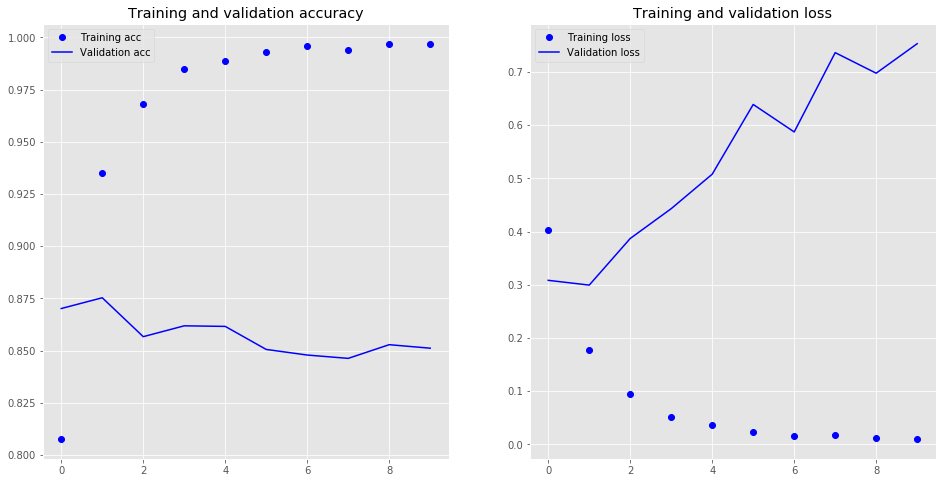

In [72]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = list(range(len(acc)))

fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].plot(acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()

## Evaluate

Finally lets evaluate the model on some previously unseen data.

In [75]:
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)

25000/25000 [==============================] - 2s 82us/step


In [76]:
score

0.7531567233657837

In [77]:
acc

0.8511200000190735

# References

[Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)